# Attention Layer

## Import Lib

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.xpu import device
from torchvision import models
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

import gpytorch

import matplotlib.pyplot as plt
import numpy as np
import random

In [30]:
# Set a fixed seed value
seed_value = 40
# Set the random seed for Python's built-in random module
random.seed(seed_value)
# Set the random seed for NumPy
np.random.seed(seed_value)
# Set the random seed for PyTorch
torch.manual_seed(seed_value)

# If using CUDA, set the seed for GPU as well (if applicable)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed_value)

In [31]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

## Data Preparation

In [32]:
class DatasetGenerator:
    def __init__(self, mnist_data, n_bags=1000, min_instances=3, max_instances=5):
        self.mnist_data = mnist_data
        self.n_bags = n_bags
        self.min_instances = min_instances
        self.max_instances = max_instances
        self.empty_image = torch.zeros(1, 28, 28)  # Create an empty image tensor (1x28x28)

    def create_bags(self):
        bags = []
        labels = []
        
        for _ in range(self.n_bags):
            # Randomly choose a number of instances for the bag
            n_instances = np.random.randint(self.min_instances, self.max_instances + 1)
            
            # Randomly select instances from the dataset
            bag_indices = np.random.choice(len(self.mnist_data), n_instances, replace=False)
            bag_images = [self.mnist_data[i][0] for i in bag_indices]
            
            # Determine the label: 1 if any instance is '9', else 0
            label = 1 if any(self.mnist_data[i][1] == 9 for i in bag_indices) else 0
            
            # Convert images to tensors and pad to ensure exactly 7 instances
            bag_images_tensors = [ToTensor()(img) for img in bag_images]
            while len(bag_images_tensors) < 7:
                bag_images_tensors.append(self.empty_image)  # Pad with empty image
            
            bags.append(torch.stack(bag_images_tensors))
            labels.append(label)

        return bags, labels

class TrainDatasetGenerator(DatasetGenerator):
    def __init__(self, mnist_data, n_bags=1000):
        super().__init__(mnist_data, n_bags)

class TestDatasetGenerator(DatasetGenerator):
    def __init__(self, mnist_data, n_bags=500):  # Example: fewer bags for testing
        super().__init__(mnist_data, n_bags)

In [33]:
# Load MNIST dataset
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True)

# Create training dataset generator and generate bags
train_generator = TrainDatasetGenerator(mnist_dataset)
train_bags, train_labels = train_generator.create_bags()
train_loader = DataLoader(list(zip(train_bags, train_labels)), batch_size=32, shuffle=True)

# Create test dataset generator and generate bags
test_generator = TestDatasetGenerator(mnist_dataset)
test_bags, test_labels = test_generator.create_bags()
test_loader = DataLoader(list(zip(test_bags, test_labels)), batch_size=16, shuffle=True)

## Attention Layer

### Self-Attention

In [34]:
class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        # Linear layers for query, key, and value transformations
        self.query = nn.Linear(input_dim, input_dim)  # Shape: (input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)    # Shape: (input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)  # Shape: (input_dim, input_dim)
        self.softmax = nn.Softmax(dim=2)              # Softmax along the last dimension

    def forward(self, x):  # x.shape: (batch_size, seq_length, input_dim) # seq_length = num_instances
        # Transform the input into queries, keys, and values
        queries = self.query(x)  # Shape: (batch_size, seq_length, input_dim)
        keys = self.key(x)       # Shape: (batch_size, seq_length, input_dim)
        values = self.value(x)   # Shape: (batch_size, seq_length, input_dim)

        # Compute attention scores
        score = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim ** 0.5)
        # Shape of score: (batch_size, seq_length, seq_length)

        attention = self.softmax(score)  
        # Shape of attention: (batch_size, seq_length, seq_length)

        weighted = torch.bmm(attention, values)  
        # Shape of weighted: (batch_size, seq_length, input_dim)

        return weighted, attention  # Returns weighted output and attention scores

### Attention Layer

In [35]:
class AttentionLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim=512):
        super(AttentionLayer, self).__init__()
        # Sequential model for attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),  # Shape: (input_dim, hidden_dim)
            nn.Tanh(),                          # Activation function
            nn.Linear(hidden_dim, 1)           # Shape: (hidden_dim, 1)
        )

    def forward(self, x):
        # x shape: (batch_size, num_instances, feature_dim)
        
        attention_weights = self.attention(x)  
        # Shape of attention_weights: (batch_size, num_instances, 1)

        weights = F.softmax(attention_weights, dim=1)  
        # Shape of weights: (batch_size, num_instances, 1)

        # Element-wise multiplication followed by summation over num_instances
        weighted_sum = (x * weights).sum(dim=1)  
        # Shape of weighted_sum: (batch_size, feature_dim)

        return weighted_sum, weights.squeeze(-1)  
        # Returns weighted sum and attention weights with shape (batch_size, num_instances)

## Gaussian Process Layer

In [36]:
class GPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

## MIL Model

In [37]:
class MILResNet18(nn.Module):
    def __init__(self, attention_method='self-attention'):
        super(MILResNet18, self).__init__()
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        self.resnet.fc = nn.Identity()
        
        self.attention_method = attention_method
        
        self.classifier = nn.Linear(512 + 1, 1)
        if attention_method != 'self-attention':
            self.attention = AttentionLayer(input_dim=512)
        else:
            self.attention = SelfAttention(input_dim=512)
            
        self.dropout = nn.Dropout(0.5)
        # Define inducing points for the GP layer
        inducing_points = torch.randn(32, 512)
        # inducing_points = torch.full((512, 512), 1e-20)  
        self.gp_layer = GPModel(inducing_points)    

    def forward(self, bags):
        # Input shape: torch.Size([32, 7, 1, 28, 28]) # batch_size, num_instances, channels, height, width
        batch_size, num_instances = bags.size(0), bags.size(1)
        bags_flattened = bags.view(-1, *bags.shape[2:])

        features = self.resnet(bags_flattened)
        features = features.view(batch_size, num_instances, -1)
        attended_features, attended_weights = self.attention(features)
        
        if self.attention_method != 'self-attention':
            attended_features_reshaped = attended_features.view(-1, 512) # Shape: (batch_size * num_instances, feature_dim)
        else:
            # Shape of attended_features: (batch_size, num_instances, feature_dim) 
            attended_features_reshaped = attended_features.mean(dim=1) # Shape: (batch_size, feature_dim)
            
        gp_output = self.gp_layer(attended_features_reshaped)
        gp_mean = gp_output.mean.view(batch_size, -1)
        if self.attention_method != 'self-attention':
            combine_features = torch.cat((attended_features, gp_mean), dim=1)
        else: 
            combine_features = torch.cat((attended_features_reshaped, gp_mean), dim=1)
            
        combine_features = self.dropout(combine_features)
        outputs = torch.sigmoid(self.classifier(combine_features))
        return outputs, attended_weights

## Training Process

### Loss Function

In [38]:
def combined_loss(outputs, gp_distribution, target, alpha=0.5):
    # Cross-Entropy Loss for CNN outputs
    bce_loss = nn.BCELoss()(outputs.squeeze(), target.float())
    kl_divergence = gp_distribution.variational_strategy.kl_divergence()
    total_loss = (1 - alpha) * bce_loss + alpha * kl_divergence
    
    return total_loss

### Training Loop

In [39]:
def train(model, dataloader, epochs=5):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    criterion = nn.BCELoss()

    model.train()

    for epoch in range(epochs):
        all_labels = []
        all_outputs = []
        total_loss = 0

        for batch_images, batch_labels in dataloader:
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs, attended_weights = model(batch_images.float())
            
            loss = combined_loss(outputs.squeeze(), model.gp_layer, batch_labels)
            
            total_loss += loss.item()

            # Backward pass
            loss.backward()
            optimizer.step()

            # Collect outputs and labels for metrics calculation
            all_labels.extend(batch_labels.cpu().numpy())
            all_outputs.extend((outputs.squeeze().cpu().detach().numpy() > 0.5).astype(int))  # Binarize outputs

        # Calculate metrics
        avg_loss = total_loss / len(dataloader)
        accuracy = accuracy_score(all_labels, all_outputs)
        recall = recall_score(all_labels, all_outputs)
        precision = precision_score(all_labels, all_outputs)
        f1 = f1_score(all_labels, all_outputs)

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, '
              f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f},F1 Score: {f1:.4f}')


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MILResNet18(attention_method='self-attention').to(device)
model.to(device)

train(model, train_loader)

Epoch [1/5], Loss: 0.2952, Accuracy: 0.7320, Precision: 0.6560, Recall: 0.2671,F1 Score: 0.3796
Epoch [2/5], Loss: 0.1395, Accuracy: 0.8990, Precision: 0.8576, Recall: 0.8046,F1 Score: 0.8303
Epoch [3/5], Loss: 0.0858, Accuracy: 0.9380, Precision: 0.9016, Recall: 0.8958,F1 Score: 0.8987
Epoch [4/5], Loss: 0.0444, Accuracy: 0.9730, Precision: 0.9605, Recall: 0.9511,F1 Score: 0.9558
Epoch [5/5], Loss: 0.0388, Accuracy: 0.9720, Precision: 0.9486, Recall: 0.9609,F1 Score: 0.9547


## Testing Process

### Plot Attended Weights

#### Attention Weights Visualization

In [40]:
def plot_attended_weights(images, attended_weights):
    """
    Plots the original images and their corresponding attended weights in a single figure.

    Args:
        images (numpy array): A batch of input image arrays.
        attended_weights (numpy array): The attended weights corresponding to the images.
    """
    images = images[0]
    attended_weights = attended_weights[0]
    num_images = images.shape[0]  # Number of images to plot

    # Create subplots
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 4, 8))

    for i in range(num_images):
        axes[i].imshow(images[i].transpose(1, 2, 0))  # Change from CHW to HWC format
        axes[i].set_title(f'Image {i + 1} - {attended_weights[i]:.4f}')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

#### Self-Attention Weights Visualization

In [41]:
def plot_self_attention(images, attention_maps):
    """
    Plots the original images and their corresponding self-attention maps in a matrix format.

    Args:
        images (numpy array): A batch of input image arrays with shape (num_instances, channels, height, width).
        attention_maps (numpy array): The attention maps corresponding to the images with shape (num_instances, height, width).
    """
    num_instances = images.shape[0]  # Number of instances/images to plot
    print(f'Shape of images: {images.shape}, Shape of attention maps: {attention_maps.shape}')
    
    # Save the attention maps for each instance to txt file 
    with open('attention_maps.txt', 'w') as f:
        for i in range(num_instances):
            f.write(f'Instance {i + 1}\n')
            f.write(f'{attention_maps[i]}\n\n')

    # Create subplots with 2 columns: original images and attention maps
    fig, axes = plt.subplots(num_instances, 2, figsize=(10, num_instances * 4))

    for i in range(num_instances):
        # Plot original image
        axes[i, 0].imshow(images[i].transpose(1, 2, 0))  # Change from CHW to HWC format
        axes[i, 0].set_title(f'Original Image {i + 1}')
        axes[i, 0].axis('off')

        # Plot attention map
        axes[i, 1].imshow(attention_maps[i], cmap='jet', alpha=0.5)  # Example colormap
        axes[i, 1].set_title(f'Attention Map {i + 1}')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()


### Test Function

Accuracy: 0.9500, Precision: 0.9140, Recall: 0.9497,F1 Score: 0.9315
Shape of images: (7, 1, 28, 28), Shape of attention maps: (179, 7, 7)


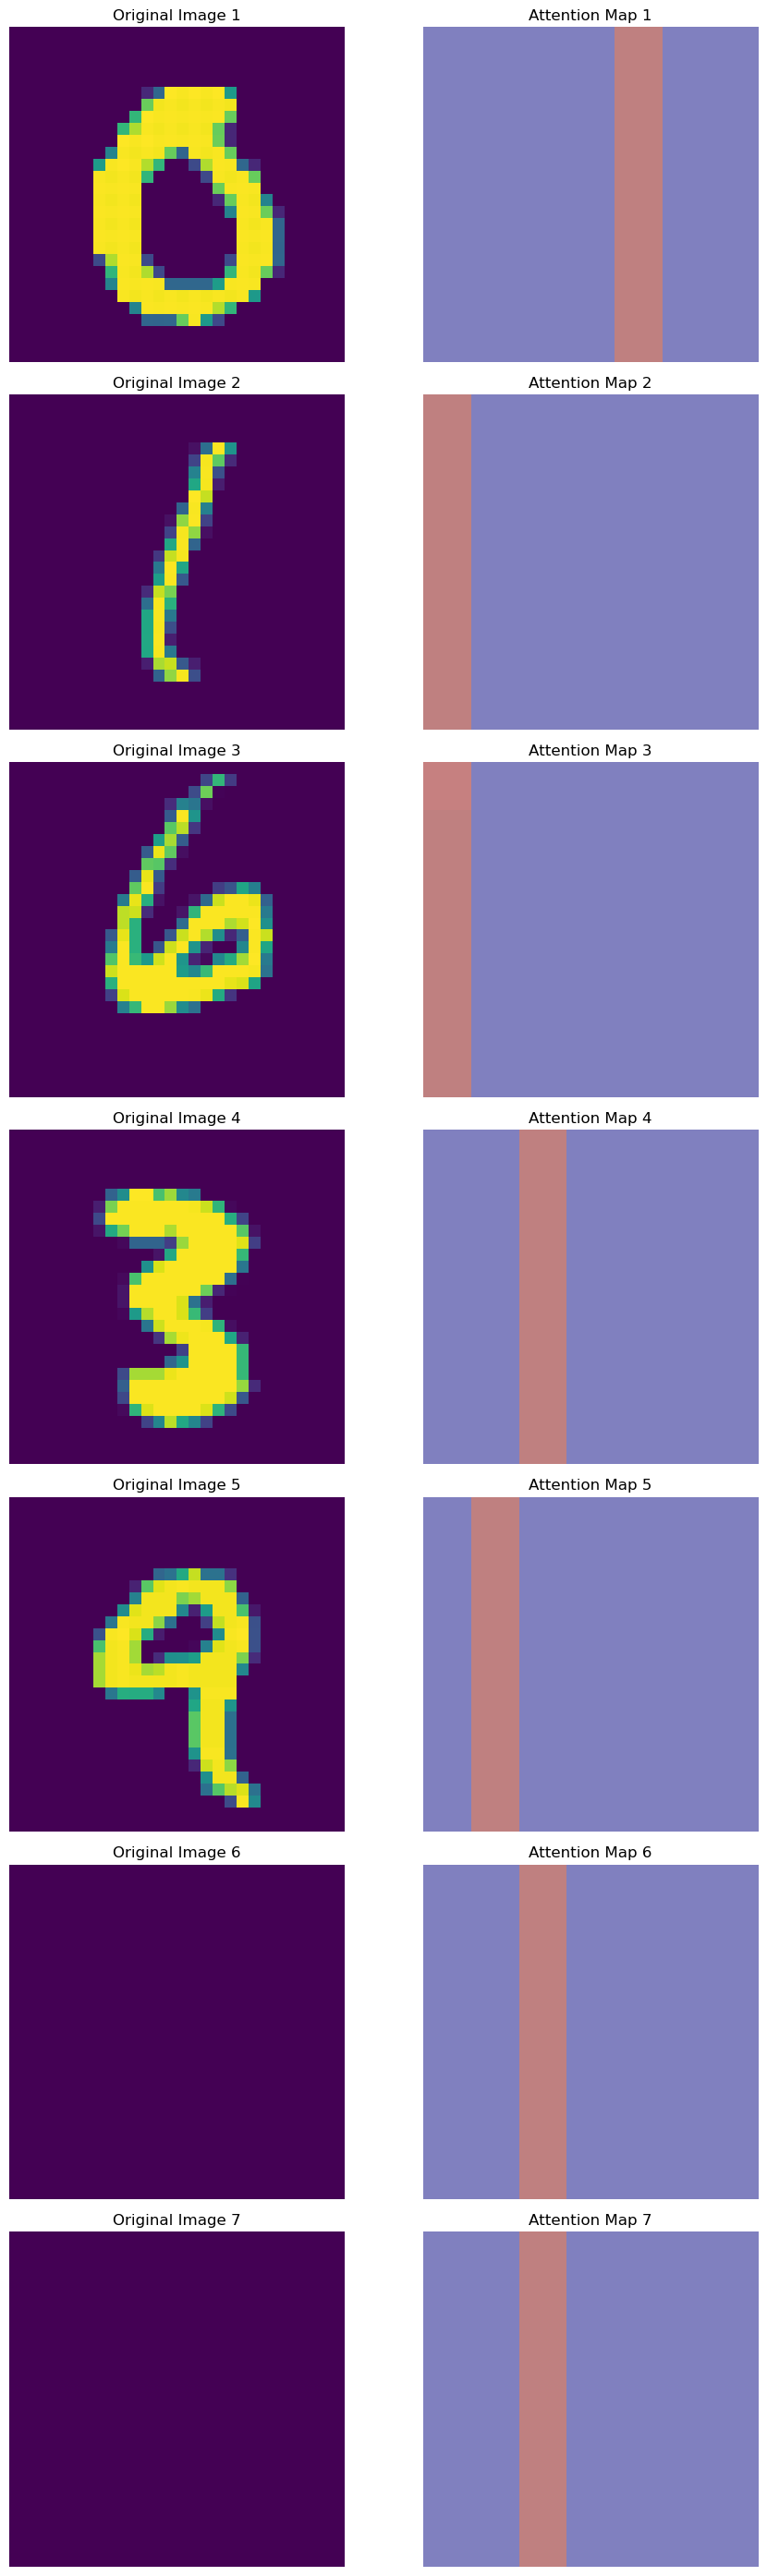

In [42]:
def test(model, dataloader):
    model.eval()
    all_labels = []
    all_outputs = []
    all_attended_weights = []  # Store attended weights for visualization
    images_to_plot = []  # Store images with label = 1
    weights_to_plot = []  # Store attended weights for images with label = 1

    with torch.no_grad():
        for batch_images, batch_labels in dataloader:
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)

            # Forward pass
            outputs, attended_weights = model(batch_images.float())
            
            # Collect outputs and labels for metrics calculation
            all_labels.extend(batch_labels.cpu().numpy())
            all_outputs.extend((outputs.squeeze().cpu().detach().numpy() > 0.5).astype(int))  # Binarize outputs

            # Check for images with label = 1
            for i in range(len(batch_labels)):
                if batch_labels[i] == 1:
                    images_to_plot.append(batch_images[i].cpu().numpy())
                    weights_to_plot.append(attended_weights[i].squeeze().cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_outputs)
    recall = recall_score(all_labels, all_outputs)
    precision = precision_score(all_labels, all_outputs)
    f1 = f1_score(all_labels, all_outputs)

    print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f},F1 Score: {f1:.4f}')

    # Plotting attended weights for images with label = 1
    if images_to_plot:  # Check if there are any images to plot
        # plot_attended_weights(np.array(images_to_plot), np.array(weights_to_plot))
        plot_self_attention(np.array(images_to_plot[0]), np.array(weights_to_plot))
        
# Call the test function with your model and test loader
test(model, test_loader)

## References:
[1] https://medium.com/@wangdk93/implement-self-attention-and-cross-attention-in-pytorch-1f1a366c9d4b